# Проверка гипотез по увеличению выручки в интернет-магазине

## Приоритизация гипотез

In [31]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [32]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [33]:
pd.set_option('max_colwidth', 120)
pd.set_option('display.width', 500)

In [34]:
data = pd.read_csv('/datasets/hypothesis.csv')

In [35]:
data.style

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [36]:
data.columns = map(str.lower, data.columns)

Применим фреймворк ICE для приоритизации гипотез:

In [37]:
data['ICE'] = (data['impact'] * data['confidence'])/data['efforts']
data_ICE = data[['hypothesis', 'ICE']].sort_values('ICE', ascending=False)
data_ICE['ICE'] = data_ICE['ICE'].round()
data_ICE

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0


По методу ICE самая перспективная гипотеза: **запустить акцию, дающую скидку на товар в день рождения.**
Затем по приоритетности идут гипотезы:
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию.


Теперь применим фреймворк RICE для приоритизации гипотез:

In [38]:
data['RICE'] = (data['reach'] * data['impact'] * data['confidence'])/data['efforts']

In [39]:
data[['hypothesis', 'RICE']].sort_values('RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


In [40]:
data['ICE'] = data['ICE'].round()

In [41]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
slice_ = ['ICE', 'RICE']
data.style.apply(highlight_max, props='color:red;', axis=0, subset=slice_)\
         .set_properties(**{'background-color': '#ffffb3'}, subset=slice_)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13,40
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1,9
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1,4
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11,112
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16,16.2


### Вывод

При применении метода RICE для приоритизации гипотез получилась другая картина:
самая перспективная гипотеза по RICE: **добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.**

Затем по приоритетности идут гипотезы:
- добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Гипотеза, которая была самой перспективной по методу ICE (запустить акцию, дающую скидку на товар в день рождения) теперь на пятом месте. Причина в том, что у неё параметр Reach равен 1, в то время как у гипотезы-лидера по RICE (добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок) он равен 10. Это означает, что гипотеза-лидер по RICE имеет намного больший охват пользователей. (параметр Reach — скольких пользователей затронет изменение, которое планируется ввести).

В целом по ICE и по RICE в лидерах одни и те же топ-5 гипотез, только приоритетности они находятся на разных позициях, в зависимости от фреймворка.

## Анализ A/B-теста

### Изучение данных и подготовка к анализу


Прочтём данные из файлов с результатами A/B-тестирования:

In [42]:
orders = pd.read_csv('/datasets/orders.csv', sep=',')
visitors = pd.read_csv('/datasets/visitors.csv', sep=',')

In [43]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))

In [44]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [45]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [46]:
orders.duplicated().sum()

0

In [47]:
visitors.duplicated().sum()

0

In [48]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [49]:
min_analysis_date = visitors['date'].min()
max_analysis_date = visitors['date'].max()
print('Минимальная дата посещений:', min_analysis_date)
print('Максимальная дата посещений:', max_analysis_date)

Минимальная дата посещений: 2019-08-01 00:00:00
Максимальная дата посещений: 2019-08-31 00:00:00


In [50]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [51]:
orders.sort_values('visitorId').head(10)

,transactionId,visitorId,date,revenue,group
56,900025958,5114589,2019-08-16,570,B
573,1887336629,6958315,2019-08-04,1490,B
71,3679129301,8300375,2019-08-01,10510,B
703,4293855558,8300375,2019-08-07,1790,A
233,797272237,11685486,2019-08-23,6201,A
912,437876380,39475350,2019-08-08,3990,B
924,3778001764,47206413,2019-08-10,730,B
951,965979600,48147722,2019-08-22,1090,B
1003,2765619353,54447517,2019-08-08,130,A
567,2952636658,56960363,2019-08-09,1490,B


In [52]:
visitorId = orders.pivot_table(index = 'visitorId', columns = 'group', values = 'transactionId', aggfunc='count')
visitorId.head(10)

group,A,B
visitorId,,
5114589,NaN,1.0
6958315,NaN,1.0
8300375,1.0,1.0
11685486,1.0,NaN
39475350,NaN,1.0
47206413,NaN,1.0
48147722,NaN,1.0
54447517,1.0,NaN
56960363,NaN,1.0


In [53]:
len(visitorId.query('A>0 and B>0'))

58

### Вывод

В нашем распоряжении две таблицы - таблица с визитами (visitors) и таблица с заказами (orders). Дубликатов и пропусков в таблицах нет. Даты мы привели к формату дат. Теперь тип данных во всех колонках соответствует значениям. В тесте есть пользователи, которые попали в две разные группы, их 58. Для корректного проведения А/В теста такого быть не должно, но удалять их без согласования с заказчиком мы не будем, тк не знаем, сколько визитов совершили эти 58 пользователей до совершения заказов. Будем иметь ввиду, что попавшие в обе группы пользователи как-то влияют на результаты теста, из-зи них результат будет менее точным.
Период проведения теста - один месяц (с 1 по 31 августа 2019 года).

### График кумулятивной выручки по группам

In [54]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates() 

In [55]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transactionId' : pd.Series.nunique, 'visitorId' : pd.Series.nunique, 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [56]:
# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

In [57]:
# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

In [58]:
cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


In [59]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

In [60]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

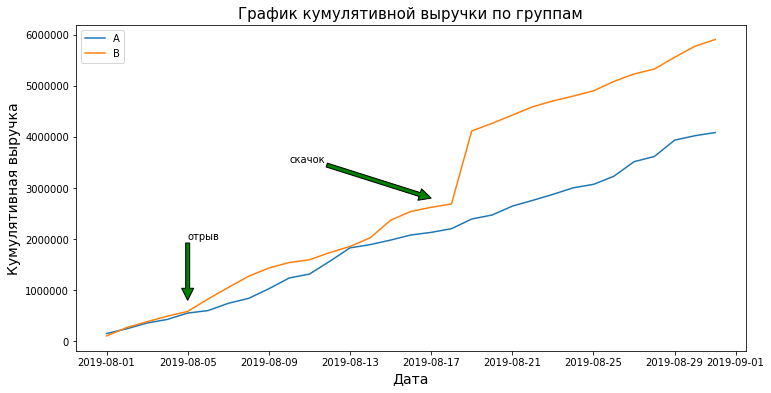

In [61]:
# Строим график выручки группы А
plt.figure(figsize =(12, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам', fontsize=15)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кумулятивная выручка', fontsize=14)
plt.annotate('скачок', xy=('2019-08-17', 2800000), xytext=('2019-08-10', 3500000),
            arrowprops=dict(facecolor='g'))
plt.annotate('отрыв', xy=('2019-08-05', 800000), xytext=('2019-08-05', 2000000),
            arrowprops=dict(facecolor='g')) 
plt.legend()
plt.show()

Выручка увеличивается в течение всего теста сначала равномерно в обеих группах, а затем чуть позже середины теста график группы В в одной точке резко растет и группа В начинает лидировать весь остаток теста. Это может сигнализировать о всплеске числа заказов, либо о появлении очень дорогих заказов в выборке. 

### График кумулятивного среднего чека по группам

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

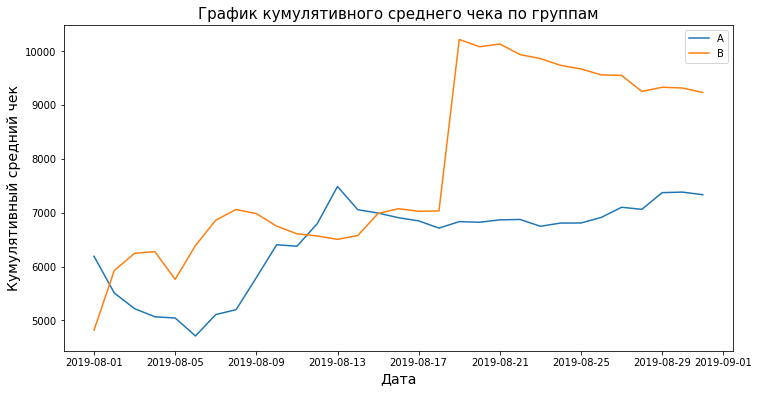

In [62]:
plt.figure(figsize =(12, 6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График кумулятивного среднего чека по группам', fontsize=15)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Кумулятивный средний чек', fontsize=14)
plt.legend()

Кумулятивное значение среднего чека по сегментам сильно колеблется. Принимать решение по этой метрике рано. Требуется дополнительный анализ выбросов, которые могут искажать результаты.

### График относительного изменения кумулятивного среднего чека группы B к группе A

In [63]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

Text(0, 0.5, 'Относительное различие')

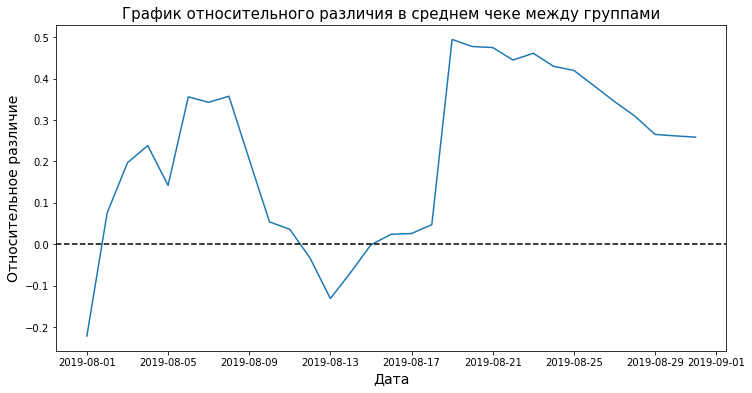

In [64]:
# cтроим отношение средних чеков
plt.figure(figsize =(12, 6))
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного различия в среднем чеке между группами', fontsize=15)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Относительное различие', fontsize=14)

В нескольких точках график различия между сегментами резко «скачет». Видимо, именно тогда были совершены аномальные заказы.

### График кумулятивной конверсии по группам.

In [65]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

In [66]:
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

In [67]:
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

['2019-07-31', '2019-09-01', 0, 0.05]

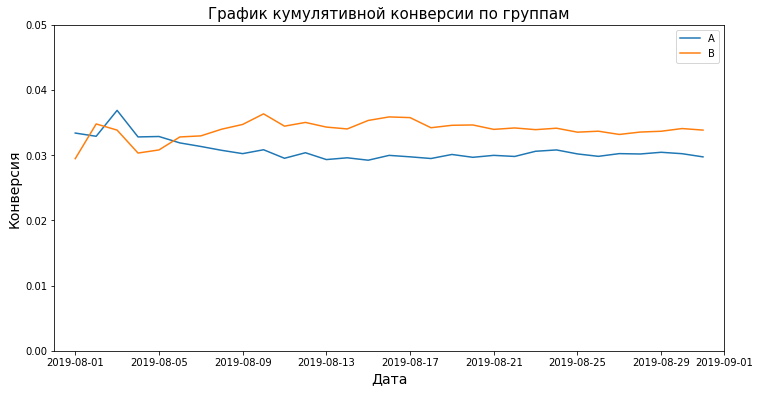

In [68]:
# строим графики
plt.figure(figsize =(12, 6))
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('График кумулятивной конверсии по группам', fontsize=15)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Конверсия', fontsize=14)
plt.legend()

# задаем масштаб осей
plt.axis(["2019-07-31", '2019-09-01', 0, 0.05])

Некоторое время в начале сегмент А имел большую конверсию, но  сегмент В выровнялся и зафиксировался примерно около одного значения, больше чем значения сегмента А.

### График относительного изменения кумулятивной конверсии

In [69]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

In [70]:
mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1

0    -0.117637
1     0.057503
2    -0.082045
3    -0.075398
4    -0.062659
5     0.028655
6     0.051764
7     0.105562
8     0.147998
9     0.178524
10    0.166894
11    0.153001
12    0.169860
13    0.149508
14    0.208611
15    0.196741
16    0.202231
17    0.160047
18    0.148564
19    0.167169
20    0.132949
21    0.146582
22    0.108338
23    0.108165
24    0.110494
25    0.129238
26    0.097221
27    0.111443
28    0.105957
29    0.127550
30    0.138079
dtype: float64

Text(0, 0.5, 'Относительное различие')

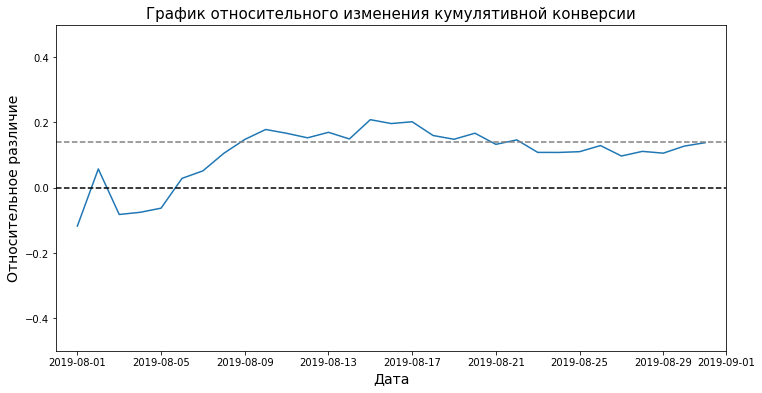

In [71]:
plt.figure(figsize =(12, 6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.139, color='grey', linestyle='--')
plt.axis(["2019-07-31", '2019-09-01', -0.5, 0.5])
plt.title('График относительного изменения кумулятивной конверсии', fontsize=15)
plt.xlabel('Дата', fontsize=14)
plt.ylabel('Относительное различие', fontsize=14)


Почти с самого начала теста группа В лидирует по конверсии и зафиксировалась около прироста в 14% относительно группы А.

### Точечный график количества заказов по пользователям

In [72]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Подсчитаем количество заказов по пользователям и посмотрим на результат:

In [73]:
ordersByUsers = (
    orders.drop(['group', 'revenue', 'date'], axis=1)
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)

ordersByUsers.columns = ['userId', 'orders']


In [74]:
ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,userId,orders
1023,4256040402,11
591,2458001652,11
569,2378935119,9
487,2038680547,8
44,199603092,5
744,3062433592,5
55,237748145,5
917,3803269165,5
299,1230306981,5
897,3717692402,5


Есть пользователи, которые совершали 8, 9 и 11 заказов.

Построим гистрограмму распределения количества заказов на одного пользователя.

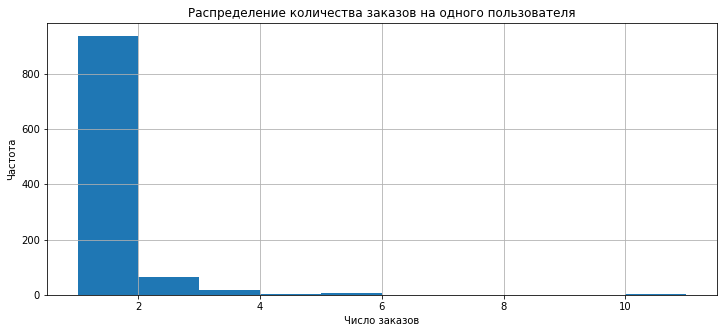

In [75]:
plt.figure(figsize= (12,5))
ordersByUsers['orders'].hist().set(title = 'Распределение количества заказов на одного пользователя', xlabel = 'Число заказов', ylabel = 'Частота')
plt.show()

Большинство покупателей заказывали только один раз. Однако доля пользователей с 2-4 заказами тоже значительна.

Построим точечную диаграмму числа заказов на одного пользователя:

Text(0, 0.5, 'Частотность')

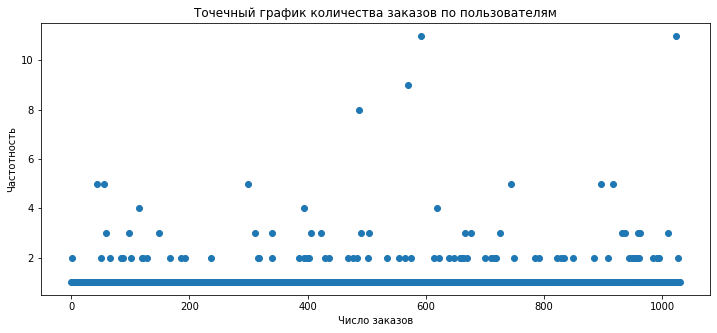

In [76]:
plt.figure(figsize= (12,5))
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.title('Точечный график количества заказов по пользователям', fontsize=12)
plt.xlabel('Число заказов', fontsize=10)
plt.ylabel('Частотность', fontsize=10)


Выводы подтверждаются: много пользователей с 2-4 заказами. Их точная доля не ясна — непонятно, считать их аномалиями или нет.

Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [77]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Не более 5% пользователей совершали больше двух заказов. И не более 1% пользователей - больше четырёх заказов.

Примем за аномальных пользователей тех, кто совершил 4 заказа и более. Так мы уберём 1% пользователей с наибольшим числом заказов.

### Точечный график стоимостей заказов

In [78]:
orders.sort_values(by='revenue', ascending=False).head(10)

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B
858,192721366,1316129916,2019-08-27,93940,A
1136,666610489,1307669133,2019-08-13,92550,A
744,3668308183,888512513,2019-08-27,86620,B
682,1216533772,4266935830,2019-08-29,78990,B
662,1811671147,4266935830,2019-08-29,78990,A
743,3603576309,4133034833,2019-08-09,67990,A
1103,1348774318,1164614297,2019-08-12,66350,A
1099,316924019,148427295,2019-08-12,65710,A


Есть заказы стоимостью 1 294 500 руб, 202 740 руб. 

Построим точечную диаграмму стоимостей заказов:

Text(0, 0.5, 'Стоимость заказа')

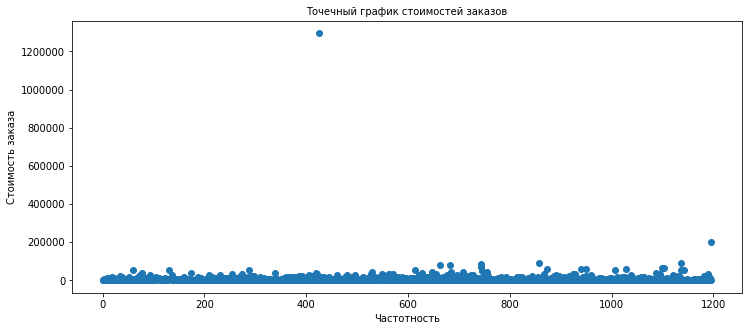

In [79]:
plt.figure(figsize= (12,5))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечный график стоимостей заказов', fontsize=10)
plt.xlabel('Частотность', fontsize=10)
plt.ylabel('Стоимость заказа', fontsize=10)

Заказов стоимостью выше 93940 рублей всего два. Заказ на почти на 1,3 миллиона в интернет-магазине выглядит весьма аномально. 

Посчитаем 95-й и 99-й перцентили стоимости заказов:

In [80]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не более, чем у 5% заказов чек дороже 28 000 рублей. И не больше, чем у 1% заказов - дороже 58 233 рублей.

Примем за аномальных пользователей тех, кто совершил заказ на сумму свыше 50 000 рублей. Так мы уберём от 1% до 5% заказов с наибольшей стоимостью.

### Расчет статистической значимости различий в конверсии и среднем чеке между группами по «сырым» данным

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.
Начнём с подготовки данных. Соберём таблицу data:

In [81]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Значения столбцов таблицы data:</p>
* date — дата;
* ordersPerDateA — количество заказов в выбранную дату в группе A;
* revenuePerDateA — суммарная выручка в выбранную дату в группе A;
* ordersPerDateB — количество заказов в выбранную дату в группе B;
* revenuePerDateB — суммарная выручка в выбранную дату в группе B;
* ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
* revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
* ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
* revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
* visitorsPerDateA — количество пользователей в выбранную дату в группе A;
* visitorsPerDateB — количество пользователей в выбранную дату в группе B;
* visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
* visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия в конверсии между группами.

**Нулевая гипотеза H₀:**<br>
Конверсия группы А равна конверсии группы В

**Альтернативная гипотеза H₁:**<br>
Конверсии групп А и В различаются

Создадим переменные ordersByUsersA и ordersByUsersB. В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

In [82]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

In [83]:
ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. Тем, кто ничего не заказал, будут соответствовать нули. 

In [84]:
sampleA = pd.concat([ordersByUsersA['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])), name='orders')],axis=0)

In [85]:
sampleB = pd.concat([ordersByUsersB['orders'],pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])), name='orders')],axis=0)

Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.

In [86]:
"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB, alternative = 'two-sided')[1])

'0.017'

Выведем относительный прирост конверсии группы B. Округлим до трёх знаков после запятой.

In [87]:
"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1)

'0.138'

P-value = 0.017 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Анализ "сырых" данных сообщает, что в конверсии между группами есть статистически значимые различия. Относительный прирост конверсии группы В к конверсии группы А равен 13.8% — второе число в выводе.

Посчитаем статистическую значимость различий в среднем чеке заказа между группами.

**Нулевая гипотеза H₀:**<br>
Средний чек пользователей группы А равен среднему чеку пользователей группы В

**Альтернативная гипотеза H₁:**<br>
Средние чеки пользователей групп А и В различаются

Чтобы рассчитать статистическую значимость различий в среднем чеке между сегментами, передадим критерию mannwhitneyu() данные о выручке с заказов.
А ещё найдём относительные различия в среднем чеке между группами:

In [88]:
'{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'], alternative = 'two-sided')[1])

'0.729'

In [89]:
'{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)

'0.259'

P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы А значительно ниже среднего чека группы В (относительное различие между сегментами 25,9%)

### Расчет статистической значимости различий в конверсии и среднем чеке между группами по «очищенным» данным.

Мы решили принять за аномальных пользователей тех, кто совершил 4 заказа и более и тех, кто совершил заказ на сумму свыше 50 000 рублей.

Узнаем, сколько всего аномальных пользователей. Сделаем срезы пользователей с числом заказов больше 4 — usersWithManyOrders и пользователей, совершивших заказы дороже 50 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers

In [90]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 4]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 4]['userId'],
    ],
    axis=0,
)

In [91]:
usersWithExpensiveOrders = orders[orders['revenue'] > 50000]['visitorId']

In [92]:
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
abnormalUsers.head(5)

1099     148427295
1137     759473111
949      887908475
744      888512513
1103    1164614297
dtype: int64

In [93]:
len(abnormalUsers)

21

Всего 21 аномальных пользователя.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

**Нулевая гипотеза H₀:**<br>
Конверсия группы А равна конверсии группы В

**Альтернативная гипотеза H₁:**<br>
Конверсии групп А и В различаются

In [94]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [95]:
sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [96]:
'{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered, alternative = 'two-sided')[1])

'0.01185'

In [97]:
'{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)

'0.160'

Результаты по конверсии не сильно изменились. Как и в случае с сырыми данными, статистическая значимость достигнута. Сегмент В лучше сегмента А.

Посмотрим, произошло ли что-нибудь с результатами по среднему чеку:

**Нулевая гипотеза H₀:**<br>
Средний чек пользователей группы А равен среднему чеку пользователей группы В

**Альтернативная гипотеза H₁:**<br>
Средние чеки пользователей групп А и В различаются

In [98]:
'{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'], alternative = 'two-sided'
        )[1]
    )

'0.715'

In [99]:
"{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )

'0.032'

P-value практически не изменился, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Разница между сегментами сократилась с 25,9% до 3,2%, но по прежнему средний чек группы А ниже среднего чека группы В.

### Вывод

- Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий. Сегмент В лучше сегмента А.
- Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;
- График различия конверсии между группами сообщает, что результаты группы B лучше группы A. Почти с самого начала теста группа В лидирует по конверсии и зафиксировалась около прироста в 14% относительно группы А.
- График различия среднего чека колеблется: он-то и позволил вам найти аномалии. Сделать из этого графика определённые выводы нельзя.

Исходя из фактов выше следует остановить тест, признать его успешным и перейти к проверке следующей гипотезы.

## Вывод

Приоритизация гипотез по фреймворку ICE показала, что первой следует проверить гипотезу о запускеь акции, дающей скидку на товар в день рождения. По фреймворку RICE самой перспективной оказалась гипотеза - добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок. Приоритизация гипотез при применении RICE вместо ICE изменилась из-за параметра, который указывает на охват пользователей, которых затронет изменение. У гипотезы о добавлении формы подписки охват значительно больше, чем у гипотезы о запуске акции со скидкой в день рождения.

Анализ А/В теста показал, что по конверсии между группами A и B (как по сырым данным, так и по очищенным) есть статистически значимые различия. А по среднему чеку между группами A и B (как по сырым данным, так и по очищенным) нет статистически значимых различий. Данный тест можно остановить и считать успешно проведенным. Конверсия из пользователя в покупателя у группы B статистически значимо выше, чем у группы A. При этом средний чек между группами не отличается.

В процессе работы были найдены пользователи, которые от сессии к сессии могли видеть как одну версию сайта, так и другую, что нарушает один из основных принцип работы A/B-теста.
В связи с этим, нам необходимо проверить корректность отработки метода показа пользователям одной или другой версии сайта и поправить его, чтобы одному и тому же пользователю показывалась только та версия сайта, которую он увидел при первом визите.